# Processing TAHMO data
This notebook converts the .csv files downloaded using the TAHMO API to netCDF and consistent formatting. It further also processes the data by calculating mean, max and min temperatures, as well as calculating th potential evaporation of the stations. These values are then saved to netCDF which can be interpreted by the Kriging interpolation notebook.

Known issue: Latitude not yet imported from station but rather constant value. Estimated impact low because of averaging in later stage. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os.path
import pathlib
import platform 
import json 
import geopandas as gpd
import sys
import xarray as xr
from shapely.geometry import Point

## Importing the required TAHMO data

In [2]:
#Resolves the datapaths for the original writers of the code. Replace with your own correct values.
cwd = pathlib.Path().resolve()
src = cwd.parent
data = src.parent.parent.parent
root = src.parent
OS_type = platform.system()
sys.path.append(str(src))
sys.path.append(str(root))
from utils.file_imports import *


data_paths = file_paths(root, TAHMO = True)
raw_files = data_paths[0]
processed_files = data_paths[1]


The first entry is pointing to /Users/matskerver/Documents/data_tana/TAHMO/raw_TAHMO, the second one to /Users/matskerver/Documents/data_tana/TAHMO/processed_TAHMO and the third one to /Users/matskerver/Documents/data_tana/TAHMO/interpolated_TAHMO. Animations will be located in /Users/matskerver/Documents/data_tana/TAHMO/results


In [3]:
# Imports all the .csv files downloaded using the API of TAHMO

data_files = glob.glob(os.path.join(raw_files, '*.csv'))
dataframes = {}

for file in data_files:
    station_name = os.path.splitext(os.path.basename(file))[0].split('_')[0]
    df = pd.read_csv(file, index_col = 0, sep =',', parse_dates = True)
    dataframes[station_name] = df


## Processing functions
These three functions are used to calculate the Evaporation (Oudin_evap) and Extra terrestial radiation (Extra_rad). The final function (process_dataframe) handles the dataframes and puts them in the correct formatting for use in the later stages.

In [4]:
def Oudin_evap(df, Ta, Re):
    lam = 2.45  # Latent heat of vaporization [MJ/kg]
    rho = 1000  # Water density [kg/m3]

    # Calculate potential evaporation (Pe). Ensure Ta is in degrees Celsius and Re is in MJ/m2/day 
    # It is then stored in a dataframe and returned
    Pe = np.where(Ta + 5 > 0, Re * (Ta + 5) / (lam * rho), 0)
    Pe_df = pd.DataFrame({'Pe': Pe}, index=Ta.index)
    
    return Pe_df

In [5]:
def Extra_rad(Tmax, Tmin, df, lat):
    # This cell calculates the extraterrestial radiation at the location of the TAHMO station.
    # To calculate this data it uses the latitude and temperature data to calculate this value. 
    
    G = 0.0820 # Solar constant [MJ/m^2/min] 

    #calculate the angle from latitude of station and get the dates from the dataframe.
    phi = np.pi / 180 * lat
    J = df.index.dayofyear.values  
    
    # Calculation of the extraterrestrial radiation: Ra. It is then stored in a dataframe and returned.
    dr = 1 + 0.033 * np.cos(2 * np.pi * J / 365)
    delta = 0.409 * np.sin((2 * np.pi * J / 365) - 1.39)
    w = np.arccos(- np.tan(phi) * np.tan(delta))
    Ra = ((24 * 60) / np.pi) * G * dr * (w * np.sin(phi) * np.sin(delta) + np.cos(phi) * np.cos(delta) * np.sin(w)) #* 10 ** - 6
    Ra_df = pd.DataFrame({'Ra': Ra}, index=df.index)

    return Ra_df

In [6]:
def process_dataframe(df):
    # Convert the index to datetime
    df.index = pd.to_datetime(df.index)
    
    # Calculate daily mean, minimum and maximum temperature.
    df_temp_mean = df['te'].resample('D').mean()
    df_temp_min = df['te'].resample('D').min()
    df_temp_max = df['te'].resample('D').max()
    
    # Calculate daily precipitation sum of station
    df_pr_daily = df['pr'].resample('D').sum()
    
    # Calculate extraterrestrial radiation of station
    lat = -1.071545386681787  # Latitude for calculation
    df_ra = Extra_rad(df_temp_max, df_temp_min, df, lat)
    df_ra_daily = df_ra.resample('D').mean()
   
    # Calculate the mean temperature of station and also use it to calculate evaporation
    df_temp_mean = df_temp_mean.squeeze()
    df_ra_daily = df_ra_daily.squeeze()
    df_evap_daily = Oudin_evap(df, df_temp_mean, df_ra_daily)

    # Concatenate all daily data into a single dataframe, rename columns for consistency.
    df_daily = pd.concat([df_pr_daily, df_temp_mean, df_temp_max, df_temp_min, df_ra_daily, df_evap_daily], axis=1)
    df_daily.columns = ['pr', 'te_mean', 'te_max', 'te_min', 'ra_mean', 'evap']
    
    return df_daily

## Data cleanup

In [7]:
# Dataset from TAHMO contained three files with strange formatting, presumably due to an error with the API 
# This cell identifies the problematic datasets and prints the corresponding keys

invalid_keys = []

for key, df in dataframes.items():
    # Check if 'te' and 'pr' columns are present in the dataframe
    if 'te' not in df.columns or 'pr' not in df.columns:
        # Add the key to the list of invalid keys
        invalid_keys.append(key)

invalid_keys

['TA00360', 'TA00080', 'TA00166']

In [8]:
# Dataset from TAHMO contained three files with strange formatting, presumably due to an error with the API 
# This snipped solves the individual dataframes after manual inspection. For implementation with more stations 
# it is recommended to contact TAHMO or skip these 'faulty' stations 

if dataframes['TA00080'].shape[1] == 9: # This contains three values for each te, pr, ra, two of which are NaN
    dataframes['TA00080'].columns = ['te_1', 'te_2', 'te_3', 'pr_1', 'pr_2', 'pr_3', 'ra_1', 'ra_2', 'ra_3']
    dataframes['TA00080'] = dataframes['TA00080'].fillna(0.0)
    dataframes['TA00080']['te'] = dataframes['TA00080'].iloc[:, :3].sum(axis=1) #summed to fill the columns
    dataframes['TA00080']['pr'] = dataframes['TA00080'].iloc[:, 3:6].sum(axis=1)
    dataframes['TA00080']['ra'] = dataframes['TA00080'].iloc[:, 6:9].sum(axis=1)
    dataframes['TA00080'] = dataframes['TA00080'].iloc[:, 9:]  #Remove the faulty columns
    
if dataframes['TA00360'].shape[1] == 6: #similar to above
    dataframes['TA00360'].columns = ['te_1', 'te_2', 'pr_1', 'pr_2', 'ra_1', 'ra_2']
    dataframes['TA00360']['te'] = dataframes['TA00360'].iloc[:, :2].sum(axis=1)
    dataframes['TA00360']['pr'] = dataframes['TA00360'].iloc[:, 2:4].sum(axis=1)
    dataframes['TA00360']['ra'] = dataframes['TA00360'].iloc[:, 4:6].sum(axis=1)
    dataframes['TA00360'] = dataframes['TA00360'].iloc[:, 6:]
    
if dataframes['TA00166'].shape[1] == 9: #similar to above
    dataframes['TA00166'].columns = ['te_1', 'te_2', 'te_3', 'pr_1', 'pr_2', 'pr_3', 'ra_1', 'ra_2', 'ra_3']
    dataframes['TA00166']['te'] = dataframes['TA00166'].iloc[:, :3].sum(axis=1)
    dataframes['TA00166']['pr'] = dataframes['TA00166'].iloc[:, 3:6].sum(axis=1)
    dataframes['TA00166']['ra'] = dataframes['TA00166'].iloc[:, 6:9].sum(axis=1)
    dataframes['TA00166'] = dataframes['TA00166'].iloc[:, 9:]
    

## Processing the data
Each key in the dataframes dictionary is processd individually to obtain the required data. If desired, one can be printed to show the temperature, precipitation and radiation data on each of the stations. 

In [9]:
# Run all the processing functions above for each dataframe in the dictonary

for key, df in dataframes.items():
    dataframes[key] = process_dataframe(df)

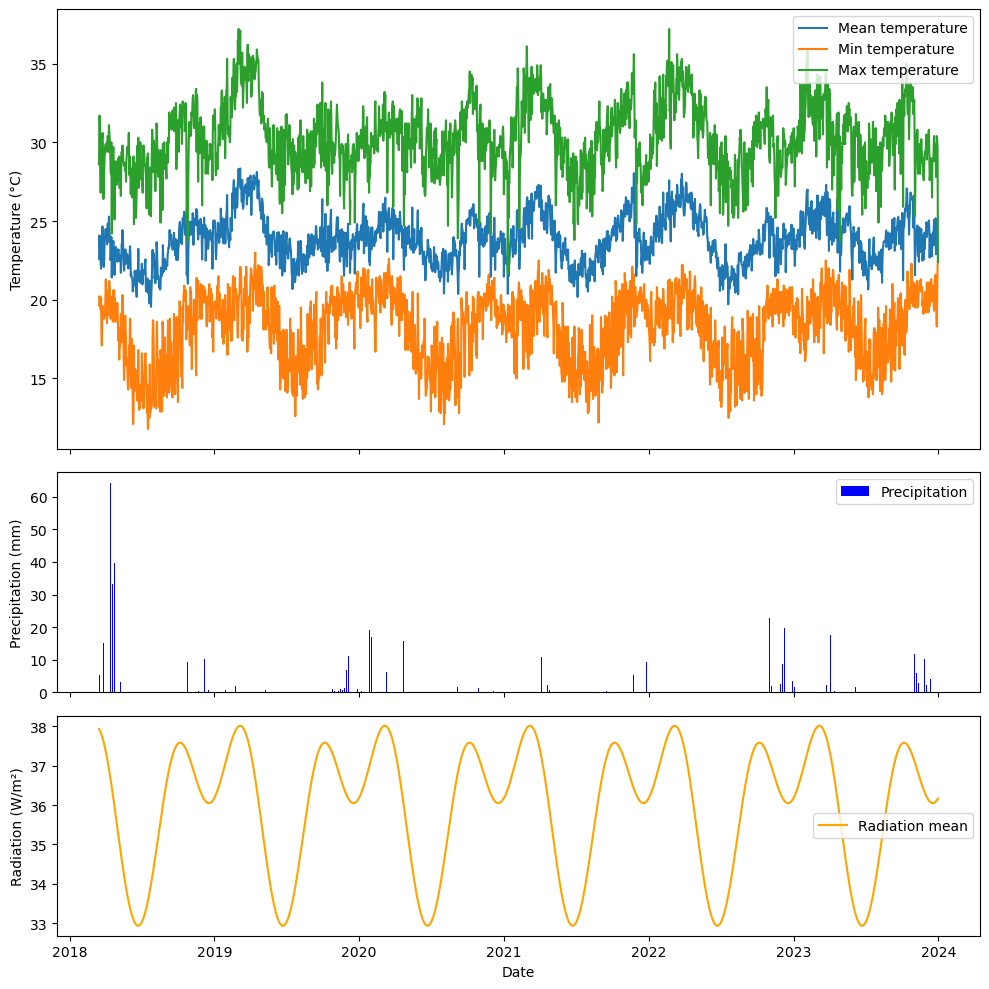

In [10]:
# If plotting_station is set to 'True' this snippet will print timeseries date of the requested TAHMO station.
plotting_station = True
df_station = dataframes['TA00023'] #change to station of interest

if plotting_station:
    
    # Three suplots are created (0,1 and 2). The first will contain all the temperature data of the station,
    # the second and third will contain the precipitation and radiation respectively. 
    # Change height ratio if desired.
    
    fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1, 1]})

    axs[0].plot(df_station.index, df_station['te_mean'], label='Mean temperature')
    axs[0].plot(df_station.index, df_station['te_min'], label='Min temperature')
    axs[0].plot(df_station.index, df_station['te_max'], label='Max temperature')
    axs[0].set_ylabel('Temperature (°C)')
    axs[0].legend()

    axs[1].bar(df_station.index, df_station['pr'], width=0.4, align='center', label='Precipitation', color='blue')
    axs[1].set_ylabel('Precipitation (mm)')
    axs[1].legend()

    axs[2].plot(df_station.index, df_station['ra_mean'], label='Radiation mean', color='orange')
    axs[2].set_ylabel('Radiation (W/m²)')
    axs[2].legend()

    plt.xlabel('Date')
    plt.tight_layout()
    plt.show()

# adding location data back onto the dataset
First a metadata file extracted from dictionary returned by TAHMO API is opened, which is used to extract location data from the TAHMO stations. 

In [11]:
#Opens the metadata file

with open(os.path.join(raw_files, 'metadata_TAHMO.txt')) as f: 
    metadata_tahmo = f.read() 
    metadata_tahmo = json.loads(metadata_tahmo) 

In [12]:
# For each station in the dataframes dictionary the location is obtained and then added to a separate dataset. 

location_name_tahmo = []
for key, value in metadata_tahmo.items():
    if key.startswith('TA'):
        location = value.get('location', {})
        name = location.get('name')
        longitude = location.get('longitude')
        latitude = location.get('latitude')
        if name and longitude is not None and latitude is not None:
            location_name_tahmo.append([key, longitude, latitude])
            

df_tahmo = pd.DataFrame(location_name_tahmo)
df_tahmo.columns = ['name', 'longitude', 'latitude']

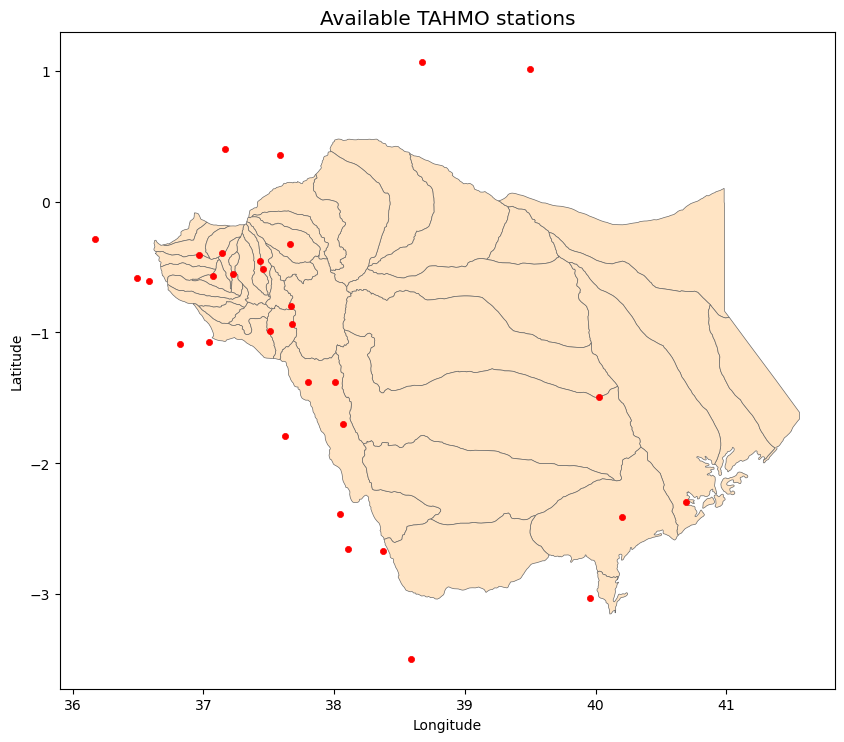

In [13]:
# Plot the GeoDataFrame if interested 

plotting = True 

if plotting:
    
    proj = 'EPSG:32737'
    # Read the geopackage file
    counties = gpd.read_file(os.path.join(raw_files, 'total_tana_catchement_area_clip_projected.gpkg'))
    
    # Assuming location_name_tahmo is defined somewhere else and has the structure [(name, lon, lat), ...]
    geometry = [Point(lon, lat) for name, lon, lat in location_name_tahmo]
    points_df = gpd.GeoDataFrame(location_name_tahmo, columns=['name', 'longitude', 'latitude'], geometry=geometry)
    points_df['longitude'] = pd.to_numeric(points_df['longitude'])
    points_df['latitude'] = pd.to_numeric(points_df['latitude'])
    points_df['geometry'] = gpd.points_from_xy(points_df['longitude'], points_df['latitude'])

    # Setup the plot with proper initialization of the 'ax' object
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    plt.style.use('bmh')

    # Plot the counties and points on the same axes
    counties.plot(ax=ax, color='bisque', edgecolor='dimgray')
    points_df.plot(ax=ax, color='red', marker='o', markersize=20)  # Plotting points with some color and marker size

    # Set the plot titles and labels
    plt.title('Available TAHMO stations')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    # Display the plot
    plt.show()

In [14]:
# This cell adds the location data back onto the dataset. If required CSV_required can be changed to True to obtain 
# individual .csv files for all stations. In the next cell the NetCDF file will be created.

CSV_required = False

for key, value in dataframes.items():    
    match = df_tahmo.iloc[:,0].values
    match_index = np.where(match == key)[0]
    dataframes[key]['longitude'] = df_tahmo.iloc[match_index[0], 1]
    dataframes[key]['latitude'] = df_tahmo.iloc[match_index[0], 2]
    if CSV_required:
        dataframes[key].to_csv(os.path.join(processed_files, f"location_data_{key}.csv"), index=True)

## Saving data
The final dataframe is saved as an netCDF file for easy processing in other notebooks. This is done using the Python xarray package, which has a similar structure.

In [15]:
# Convert each DataFrame into an xarray DataArray and then combine them into a Dataset

data_arrays = {}

for station_id, df in dataframes.items():
    #iterate through all the stations and put them in a dictionary for temporary storage
    
    df.index.name = 'time'
    data_array = xr.DataArray(df, dims=['time', 'variable'], coords={'time': df.index, 'variable': df.columns})
    data_arrays[station_id] = data_array.to_dataset(name=station_id)


#After all stations are added to the dataframe they are all merged together along their time and variable 
#dimensions and then saved as a NetCDF file for easy acces in other notebooks.

dataset = xr.merge(data_arrays.values())
dataset.to_netcdf(os.path.join(processed_files, 'NetCDF_TAHMO.nc'))